# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [34]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [35]:
# Load in the general demographics data.
azdias_orig = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter= ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter= ';')

In [36]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

## dimensions of the datasets
print('Demographics data: ', azdias_orig.shape)
print('Demographics summary data: ', feat_info.shape)

Demographics data:  (891221, 85)
Demographics summary data:  (85, 4)


In [37]:
azdias_orig.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [38]:
feat_info.head(15)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [39]:
## data frame of features that contain nan values
miss = pd.DataFrame({'pct_missing': pd.isna(azdias_orig).sum()*100/len(azdias_orig)})
miss.head()

,pct_missing
AGER_TYP,0.000000
ALTERSKATEGORIE_GROB,0.000000
ANREDE_KZ,0.000000
CJT_GESAMTTYP,0.544646
FINANZ_MINIMALIST,0.000000


In [40]:
# Identify missing or unknown data values and convert them to NaNs.
## get unknown lists from feature dataset

# features that incluse missing values
#feat_miss = feat_info[feat_info['missing_or_unknown'] != '[]']
unknowns = list(feat_info['missing_or_unknown'])
res = [x.strip("[]").split(",") for x in unknowns]
print(res[:10])

[['-1', '0'], ['-1', '0', '9'], ['-1', '0'], ['0'], ['-1'], ['-1'], ['-1'], ['-1'], ['-1'], ['-1']]


In [41]:
## create dictionary matching features with their respective missing values
miss_dict = {}

for i in range(len(feat_info)):
    miss_dict[feat_info.iloc[i,0]] = res[i]

miss_dict

{'AGER_TYP': ['-1', '0'],
 'ALTERSKATEGORIE_GROB': ['-1', '0', '9'],
 'ANREDE_KZ': ['-1', '0'],
 'CJT_GESAMTTYP': ['0'],
 'FINANZ_MINIMALIST': ['-1'],
 'FINANZ_SPARER': ['-1'],
 'FINANZ_VORSORGER': ['-1'],
 'FINANZ_ANLEGER': ['-1'],
 'FINANZ_UNAUFFAELLIGER': ['-1'],
 'FINANZ_HAUSBAUER': ['-1'],
 'FINANZTYP': ['-1'],
 'GEBURTSJAHR': ['0'],
 'GFK_URLAUBERTYP': [''],
 'GREEN_AVANTGARDE': [''],
 'HEALTH_TYP': ['-1', '0'],
 'LP_LEBENSPHASE_FEIN': ['0'],
 'LP_LEBENSPHASE_GROB': ['0'],
 'LP_FAMILIE_FEIN': ['0'],
 'LP_FAMILIE_GROB': ['0'],
 'LP_STATUS_FEIN': ['0'],
 'LP_STATUS_GROB': ['0'],
 'NATIONALITAET_KZ': ['-1', '0'],
 'PRAEGENDE_JUGENDJAHRE': ['-1', '0'],
 'RETOURTYP_BK_S': ['0'],
 'SEMIO_SOZ': ['-1', '9'],
 'SEMIO_FAM': ['-1', '9'],
 'SEMIO_REL': ['-1', '9'],
 'SEMIO_MAT': ['-1', '9'],
 'SEMIO_VERT': ['-1', '9'],
 'SEMIO_LUST': ['-1', '9'],
 'SEMIO_ERL': ['-1', '9'],
 'SEMIO_KULT': ['-1', '9'],
 'SEMIO_RAT': ['-1', '9'],
 'SEMIO_KRIT': ['-1', '9'],
 'SEMIO_DOM': ['-1', '9'],
 'SEMIO_KA

In [42]:
## some variables are categorical, so need to convert to strings in order to replace values
azdias = azdias_orig
for i in range(azdias.shape[1]):
    for key in miss_dict:
        if miss_dict[key] == ['']:
            continue
        elif miss_dict[key] ==  ['-1', 'X']:
            continue
        elif miss_dict[key] ==  ['XX']:
            continue
        elif miss_dict[key] ==  ['-1', 'XX']:
            continue
        else:
            miss_dict[key] = [int(i) for i in miss_dict[key]]

miss_dict

{'AGER_TYP': [-1, 0],
 'ALTERSKATEGORIE_GROB': [-1, 0, 9],
 'ANREDE_KZ': [-1, 0],
 'CJT_GESAMTTYP': [0],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_VORSORGER': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZTYP': [-1],
 'GEBURTSJAHR': [0],
 'GFK_URLAUBERTYP': [''],
 'GREEN_AVANTGARDE': [''],
 'HEALTH_TYP': [-1, 0],
 'LP_LEBENSPHASE_FEIN': [0],
 'LP_LEBENSPHASE_GROB': [0],
 'LP_FAMILIE_FEIN': [0],
 'LP_FAMILIE_GROB': [0],
 'LP_STATUS_FEIN': [0],
 'LP_STATUS_GROB': [0],
 'NATIONALITAET_KZ': [-1, 0],
 'PRAEGENDE_JUGENDJAHRE': [-1, 0],
 'RETOURTYP_BK_S': [0],
 'SEMIO_SOZ': [-1, 9],
 'SEMIO_FAM': [-1, 9],
 'SEMIO_REL': [-1, 9],
 'SEMIO_MAT': [-1, 9],
 'SEMIO_VERT': [-1, 9],
 'SEMIO_LUST': [-1, 9],
 'SEMIO_ERL': [-1, 9],
 'SEMIO_KULT': [-1, 9],
 'SEMIO_RAT': [-1, 9],
 'SEMIO_KRIT': [-1, 9],
 'SEMIO_DOM': [-1, 9],
 'SEMIO_KAEM': [-1, 9],
 'SEMIO_PFLICHT': [-1, 9],
 'SEMIO_TRADV': [-1, 9],
 'SHOPPER_TYP': [-1],
 'SOHO_KZ': [-

In [43]:
## use latest dictionary to convert values to NaN

## experiment with the first column
lo = azdias['ANZ_TITEL']
for x in ['']:
    lo = lo.replace(x, np.nan)

lo.isna().sum()

73499

In [44]:

for key in miss_dict:
    for x in miss_dict[key]:
        azdias[key] = azdias[key].replace(x, np.nan)

In [45]:
## showing original and updated percent of missing values 
updated_miss = pd.DataFrame({'num_missing_update': azdias.isna().sum(),'pct_miss_original': miss['pct_missing'],'pct_miss_update':azdias.isna().sum()*100/len(azdias)})
updated_miss.head()

,num_missing_update,pct_miss_original,pct_miss_update
AGER_TYP,685843,0.000000,76.955435
ALTERSKATEGORIE_GROB,2881,0.000000,0.323264
ANREDE_KZ,0,0.000000,0.000000
CJT_GESAMTTYP,4854,0.544646,0.544646
FINANZ_MINIMALIST,0,0.000000,0.000000


- Well, after parsing through the dictionary and replacing every value with a missing value, I gotta say that the updated dataset contains a lot more missing data than I thought. Well, it is obvious that a dirty dataset can include a vast number of missing values. Therefore, I look forward to see what the next steps tell me with respect to this.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


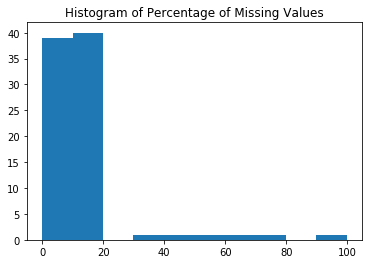

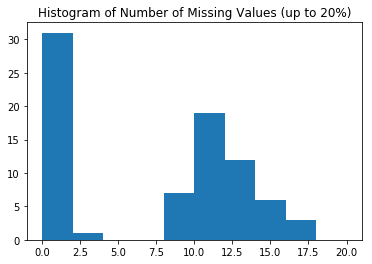

In [46]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

## plot multiple histograms with different ranges
fig1 = plt.figure(1)
plt.hist(updated_miss['pct_miss_update'])
plt.title('Histogram of Percentage of Missing Values')
fig1.show()

fig2 = plt.figure(2)
plt.hist(updated_miss['pct_miss_update'], range = (0, 20))
plt.title('Histogram of Number of Missing Values (up to 20%)')
fig2.show()


- If it is a few for proportion of missing values, need to remove columns that contain more than 25% of data missing.

In [47]:
updated_miss2 = updated_miss.sort_values(by = 'pct_miss_update', ascending=False)
updated_miss2.head(10)

,num_missing_update,pct_miss_original,pct_miss_update
TITEL_KZ,889061,8.247000,99.757636
AGER_TYP,685843,0.000000,76.955435
KK_KUNDENTYP,584612,65.596749,65.596749
KBA05_BAUMAX,476524,14.959701,53.468668
GEBURTSJAHR,392318,0.000000,44.020282
ALTER_HH,310267,8.247000,34.813699
KKK,158064,13.598872,17.735668
REGIOTYP,158064,13.598872,17.735668
W_KEIT_KIND_HH,147988,12.073549,16.605084
KBA05_ANTG1,133324,14.959701,14.959701


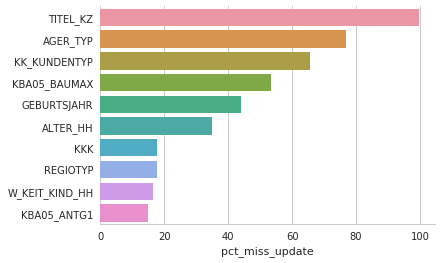

In [48]:
# Investigate patterns in the amount of missing data in each column.

## plot columns with respective number of missing values
sns.set(style="whitegrid")
ax = sns.barplot(updated_miss2.iloc[:10,2], updated_miss2.iloc[:10,:].index, orient= 'h')
sns.despine(left = True)



- All variables above KKK are outliers since those variables do not have a significantly different number of missing values between each other

In [49]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_cols = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
azdias.drop(drop_cols, axis = 1, inplace= True)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [50]:
# How much data is missing in each row of the dataset?

## Find number of missing values without the dropped columns
row_miss = pd.DataFrame({'num_miss':azdias.isnull().sum(axis = 1)})

## sort this dataset by number of missing values
row_miss.sort_values(by = 'num_miss', ascending = False, inplace= True)
row_miss.head(10)

,num_miss
732775,49
643174,49
472919,48
345274,47
299868,47
582092,47
681255,47
818343,47
582109,47
439981,47


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


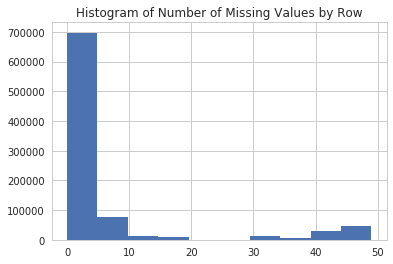

In [51]:
fig2 = plt.figure(2)
plt.hist(row_miss['num_miss'])
plt.title('Histogram of Number of Missing Values by Row')
fig2.show()

In [52]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

## divide dataset in the two threshods: 5% of missing data
## find indexes that contain more and less than 20 values missing
azdias_above_20_r = row_miss[row_miss['num_miss'] >= 20].index.tolist() 
azdias_below_20_r = row_miss[row_miss['num_miss'] < 20].index.tolist()

azdias_above_20 = azdias.iloc[azdias_above_20_r,]
azdias_below_20 = azdias.iloc[azdias_below_20_r,]

print('Azdias has', len(azdias_above_20_r), 'rows with 20 and more values missing')
print('Azdias has', len(azdias_below_20_r), 'rows with less than 20 values missing')

Azdias has 94144 rows with 20 and more values missing
Azdias has 797077 rows with less than 20 values missing


In [20]:
# How much data is missing in each row of the dataset?

## Find number of missing values without the dropped columns
updated_miss3 = updated_miss2[updated_miss2.index.isin(drop_cols) == False]

## sort this dataset by number of missing values
updated_miss3 = updated_miss3.sort_values(by = 'num_missing_update', ascending=False)
updated_miss3.tail(40)

,num_missing_update,pct_miss_original,pct_miss_update
WOHNLAGE,93148,10.451729,10.451729
LP_FAMILIE_FEIN,77792,0.544646,8.728699
LP_FAMILIE_GROB,77792,0.544646,8.728699
KONSUMNAEHE,73969,8.299737,8.299737
WOHNDAUER_2008,73499,8.247000,8.247000
SOHO_KZ,73499,8.247000,8.247000
ANZ_TITEL,73499,8.247000,8.247000
ANZ_PERSONEN,73499,8.247000,8.247000
HH_EINKOMMEN_SCORE,18348,2.058749,2.058749
LP_STATUS_GROB,4854,0.544646,0.544646


In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

## features where there are few or no missing values
subset_features = ['HH_EINKOMMEN_SCORE', 'ONLINE_AFFINITAET', 'GFK_URLAUBERTYP', 'ALTERSKATEGORIE_GROB', 'SEMIO_REL']

def compare_graphs(df1, df2, feat_list):  ## df1: less than 20 missing, df2: more than 20 missing 
    plt.figure(figsize = (14, 6))
    plt.subplot(1,2,1)
    df1[feat_list] = df1[feat_list].fillna('Missing')
    plt.tight_layout()
    plt.title(feat_list + ' Barplot for Less than 20 Missing')
    ax1 = sns.countplot(x = feat_list, data = df1)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 45)
    ax1.set_ylabel('')

    #plt.figure(figsize = (7, 4))
    plt.subplot(1,2,2)
    df2[feat_list] = df2[feat_list].fillna('Missing')
    plt.tight_layout()
    plt.title(feat_list + ' Barplot for Over 20 Missing')
    ax2 = sns.countplot(x = feat_list, data = df2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45)
    ax2.set_ylabel('')
        
    plt.show()
        

In [22]:
import warnings
warnings.filterwarnings("ignore")

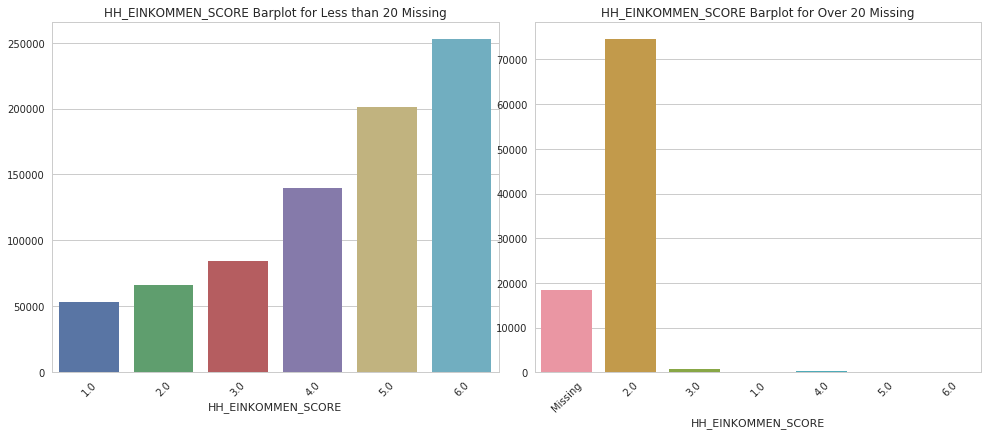

None


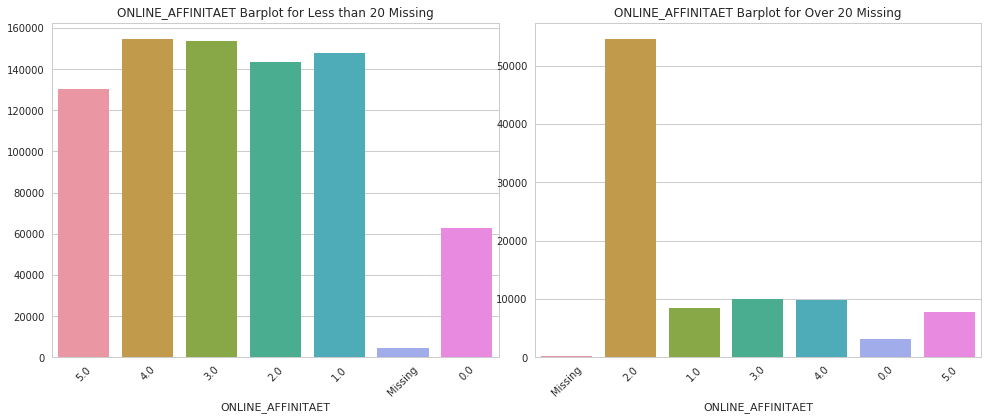

None


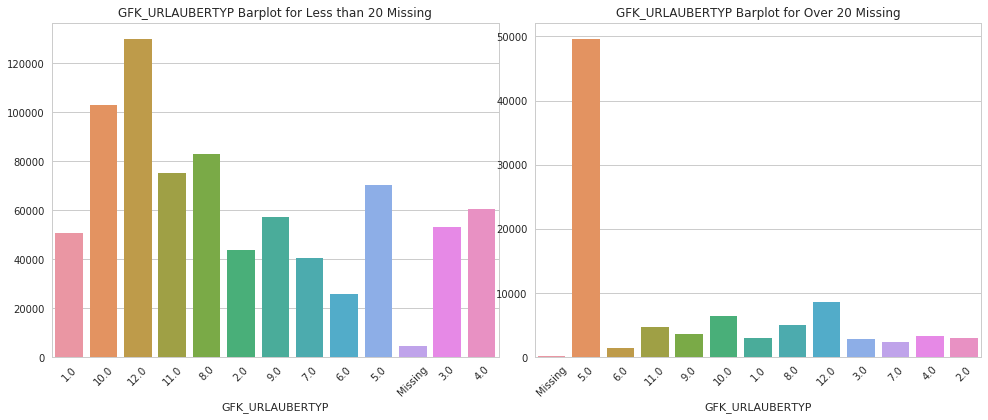

None


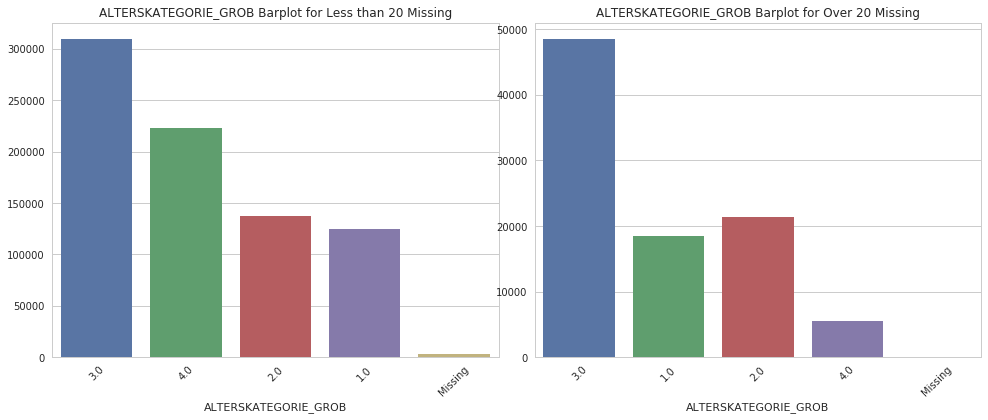

None


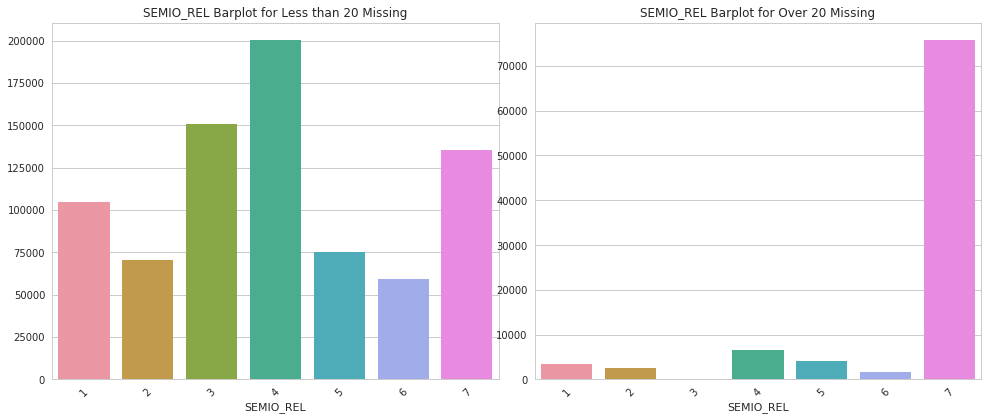

None


In [23]:
## the plots on the left are those that have rows wit less than 20 missing values
## while those on the right are those that have more thant 20 missing values data

for i in range(len(subset_features)):
    print(compare_graphs(azdias_below_20, azdias_above_20, subset_features[i]))

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

- Two subsets: 20+ missing data for the subset with a lot of missing values by row and 20- missing data for little or no missing values by row.
- By little or no missing data, I picked variables that contain 5% or less missing data. Comparing both of the plot columns above, the number of missing values across variables with little or no missing values seeem to have little or not much of a difference. 
    - It is noticeable that HH_EINKOMMEN_SCORE, which has 2% missing data, has a lot of missing values in the 20+ missing subset and none in the 20- missing subset on the left. Also, the 20- plot has an even distribution while the 20+ plot is not. In there, almost all values are 2 and very few are 3 or 4.
- Comparing the countplots for ONLINE_AFFINITAET, GFK_URLAUBERTYP,  and SEMIO_REL, the distributions for their 20+ missing data subset are very different compared to their 20- subset counterparts. Usually the 20+ missing subsets have onlyn one value that has a significantly higher frequency than the others. 
    - For instance, GFK_URLAUBERTYP has 5 with a frequency of 5000 while the others have freequency of less than 10,000. This pattern is repeated in all plotted variables except ALTERSKATEGORIE_GROB. 
- The only plot that shows similar distributions between the two sunbsets is  that of ALTERSKATEGORIE_GROB. Although this is evident, most of the other plots suggest that we should treat the 20+ subset data as special and proceed with the analysis using the 20- subset.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
## How many features are there of each data type?

## update azdias to dataframe with less than 20 missing values per row
azdias = azdias.iloc[azdias_below_20_r,] 

print('AZDIAS has ', azdias.shape[0],'rows and', azdias.shape[1], 'features')
updated_feat_info = feat_info[feat_info['attribute'].isin(azdias.columns)]
updated_feat_info['type'].value_counts()


AZDIAS has  797077 rows and 79 features


ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

- there are 18 categorical variables and 6 mixed variables, with a total of 24 variables to work on.
- Most of the variables in the dataset are ordinal, which means that their values are kept without changes

In [25]:
## get mixed and categorical features, excluding the dropped outlier features
mix_cat_feats = updated_feat_info[(updated_feat_info['type'] == 'categorical') | (updated_feat_info['type'] == 'mixed')]
mix_cat_feats.head()


,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

## gather categorical and mixed variables into a list and filter dataset according to said list
mix_cat_list = mix_cat_feats['attribute'].tolist()

## add number of values to each categorical variable and sort data from most to least levels
values = []
levels = []
for x in mix_cat_list:
    vals = azdias[x].unique()
    values.append(vals)
    levels.append(len(vals))

mix_cat_feats['values'] = values
mix_cat_feats['num_values'] = levels
mix_cat_feats['num_missing'] = list(azdias[mix_cat_list].isna().sum())
mix_cat_feats = mix_cat_feats.sort_values(by = 'num_values', ascending= False)
mix_cat_feats.head()

,attribute,information_level,type,missing_or_unknown,values,num_values,num_missing
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX],"[nan, 3B, 9C, 4A, 6B, 3C, 8A, 3A, 8C, 7A, 7C, ...",45,5867
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],"[9.0, 19.0, 23.0, 2.0, 10.0, 6.0, 12.0, 11.0, ...",41,49487
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]","[nan, 23, 51, 22, 43, 24, 54, 41, 31, 14, 25, ...",22,5867
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]","[10.0, 5.0, 11.0, 3.0, 8.0, 15.0, 14.0, 9.0, n...",16,28324
12,GFK_URLAUBERTYP,person,categorical,[],"[1.0, 10.0, 12.0, 11.0, 8.0, 2.0, 9.0, 7.0, 6....",13,4632


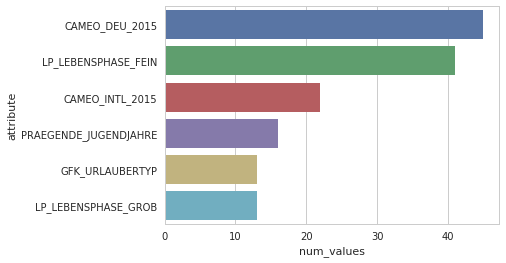

In [27]:
## create a visual for the above table
sns.barplot(x = 'num_values', y = 'attribute', data = mix_cat_feats.iloc[:6,])
plt.show()

- Set cutoff at 22 values (CAMEO_INTL_2015)

In [28]:
## at the moment, drop columns that contain 13 or more values
drop_cols = ['CAMEO_DEU_2015','LP_LEBENSPHASE_FEIN']

azdias_cat = azdias.drop(drop_cols, axis = 1)
azdias_cat.shape

(797077, 77)

In [29]:
## check mixed variables
mix_cat_feats[mix_cat_feats['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown,values,num_values,num_missing
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],"[9.0, 19.0, 23.0, 2.0, 10.0, 6.0, 12.0, 11.0, ...",41,49487
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]","[nan, 23, 51, 22, 43, 24, 54, 41, 31, 14, 25, ...",22,5867
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]","[10.0, 5.0, 11.0, 3.0, 8.0, 15.0, 14.0, 9.0, n...",16,28324
16,LP_LEBENSPHASE_GROB,person,mixed,[0],"[3.0, 5.0, 6.0, 1.0, 2.0, 9.0, 4.0, 8.0, nan, ...",13,46679
56,WOHNLAGE,building,mixed,[-1],"[3.0, 7.0, 0.0, 8.0, 5.0, 4.0, 2.0, 1.0]",8,0
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]","[nan, 3.0, 4.0, 1.0, 2.0, 5.0]",6,22382


In [57]:
## check categorical variables
mix_cat_feats[mix_cat_feats['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown,values,num_values,num_missing
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX],"[nan, 3B, 9C, 4A, 6B, 3C, 8A, 3A, 8C, 7A, 7C, ...",45,5867
12,GFK_URLAUBERTYP,person,categorical,[],"[1.0, 10.0, 12.0, 11.0, 8.0, 2.0, 9.0, 7.0, 6....",13,4632
17,LP_FAMILIE_FEIN,person,categorical,[0],"[1.0, 2.0, 4.0, 10.0, 7.0, nan, 6.0, 3.0, 9.0,...",12,30982
19,LP_STATUS_FEIN,person,categorical,[0],"[7.0, 9.0, 10.0, 1.0, 8.0, 5.0, 4.0, 2.0, 3.0,...",11,4632
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1,X]","[nan, 3, 9, 4, 6, 8, 7, 5, 2, 1]",10,5867
52,GEBAEUDETYP,building,categorical,"[-1,0]","[3.0, 1.0, 2.0, 8.0, 4.0, 6.0, 5.0]",7,0
3,CJT_GESAMTTYP,person,categorical,[0],"[5.0, 6.0, 4.0, 1.0, 3.0, 2.0, nan]",7,4632
42,ZABEOTYP,person,categorical,"[-1,9]","[6, 3, 1, 4, 5, 2]",6,0
20,LP_STATUS_GROB,person,categorical,[0],"[3.0, 4.0, 5.0, 1.0, 2.0, nan]",6,4632
18,LP_FAMILIE_GROB,person,categorical,[0],"[1.0, 2.0, 3.0, 5.0, 4.0, nan]",6,30982


In [58]:
## re-encode the variable OST_WEST_KZ and ANREDE_KZ
ost_west_dict = {'W': 1, 'O': 0} ## 1 for West Germany, 0 for East Germany
azdias_cat['OST_WEST_KZ'].replace(ost_west_dict, inplace= True)

azdias_cat['ANREDE_KZ'] = azdias_cat['ANREDE_KZ'] - 1 ## 1 for femala and 0 for male

In [59]:
# Re-encode categorical variable(s) to be kept in the analysis.

d_e_cols = ['OST_WEST_KZ', 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'LP_LEBENSPHASE_FEIN', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015'] ## do not encode columns
encode_cols = [e for e in mix_cat_list if e not in d_e_cols]
print(encode_cols)
azdias_cat_enc = pd.get_dummies(azdias_cat, columns = encode_cols)
azdias_cat_enc.head()

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'PLZ8_BAUMAX']


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
746276,3.0,0,4,3,4,2,4,1,0,1.0,...,0,0,0,0,0,0,0,0,0,0
884754,4.0,0,5,1,5,1,3,1,0,1.0,...,0,0,0,0,0,0,0,0,0,0
277633,2.0,0,4,4,1,2,5,1,1,2.0,...,0,0,0,0,0,0,0,0,0,0
506621,2.0,0,2,4,2,2,5,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
719161,2.0,1,4,4,1,4,5,1,0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
azdias_cat_enc.columns.tolist()

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELA

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- Needed to drop CAMEO_DEU_2015, and LP_LEBENSPHASE_FEIN since they have the most values and the number of values for the latter value is significantly larger than that of the former. Moreoverm, the nex step deatls with the two next largest variables -- PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [61]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
## print the unique values of "PRAEGENDE_JUGENDJAHRE"
sorted(azdias['PRAEGENDE_JUGENDJAHRE'].unique())

## decade (two digits) dictionary

# temporally change nan values to 0 so that a for loop changes it back
azdias_cat_enc['PRAEGENDE_JUGENDJAHRE'] = azdias_cat_enc['PRAEGENDE_JUGENDJAHRE'].fillna(0)
decades_p_j = {0: np.nan, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
               7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13:80, 14:90, 15:90}

## create decade (interval), movement (binary)
decade = []
for x in azdias_cat_enc['PRAEGENDE_JUGENDJAHRE']:
    decade.append(decades_p_j[x])

## add decade variable to dataframe
azdias_cat_enc['DECADE'] = decade

azdias_cat_enc.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,DECADE
746276,3.0,0,4,3,4,2,4,1,0,1.0,...,0,0,0,0,0,0,0,0,0,80.0
884754,4.0,0,5,1,5,1,3,1,0,1.0,...,0,0,0,0,0,0,0,0,0,60.0
277633,2.0,0,4,4,1,2,5,1,1,2.0,...,0,0,0,0,0,0,0,0,0,80.0
506621,2.0,0,2,4,2,2,5,2,0,2.0,...,0,0,0,0,0,0,0,0,0,80.0
719161,2.0,1,4,4,1,4,5,1,0,3.0,...,0,0,0,0,0,0,0,0,0,80.0


In [62]:
# variable: dimension - list of values
## Movement - Mainstream: [1, 3, 5, 8, 10, 12, 14]
## Movement - Avantgarde: [2, 4, 6, 7, 9, 11, 13, 15]

mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

movement = [] ## movement -> 1: mainstream, 0: avantgarde
for x in azdias_cat_enc['PRAEGENDE_JUGENDJAHRE']:
    if x in mainstream:
        movement.append(1)
    elif x in avantgarde:
        movement.append(0)
    else:
        movement.append(np.nan)
        
azdias_cat_enc['MOVEMENT_MAINSTREAM'] = movement
azdias_cat_enc.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,DECADE,MOVEMENT_MAINSTREAM
746276,3.0,0,4,3,4,2,4,1,0,1.0,...,0,0,0,0,0,0,0,0,80.0,1.0
884754,4.0,0,5,1,5,1,3,1,0,1.0,...,0,0,0,0,0,0,0,0,60.0,1.0
277633,2.0,0,4,4,1,2,5,1,1,2.0,...,0,0,0,0,0,0,0,0,80.0,0.0
506621,2.0,0,2,4,2,2,5,2,0,2.0,...,0,0,0,0,0,0,0,0,80.0,1.0
719161,2.0,1,4,4,1,4,5,1,0,3.0,...,0,0,0,0,0,0,0,0,80.0,1.0


In [63]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
sorted(azdias_cat_enc['CAMEO_INTL_2015'].unique().astype(float))

wealth = []
life_stage = []

for x in azdias_cat_enc['CAMEO_INTL_2015']:
    if pd.isnull(x):
        wealth.append(np.nan)
        life_stage.append(np.nan)
    else:
        wealth.append(x[0])
        life_stage.append(x[1])
        
azdias_cat_enc['WEALTH_INTL_2015'] = wealth
azdias_cat_enc['LIFE_STAGE_INTL_2015'] = life_stage


In [64]:
## drop 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'
azdias_cat_enc.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1, inplace= True)
azdias_cat_enc.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_9,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,DECADE,MOVEMENT_MAINSTREAM,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015
746276,3.0,0,4,3,4,2,4,1,0,1.0,...,0,0,0,0,0,0,80.0,1.0,NaN,NaN
884754,4.0,0,5,1,5,1,3,1,0,1.0,...,0,0,0,0,0,0,60.0,1.0,NaN,NaN
277633,2.0,0,4,4,1,2,5,1,1,2.0,...,0,0,0,0,0,0,80.0,0.0,NaN,NaN
506621,2.0,0,2,4,2,2,5,2,0,2.0,...,0,0,0,0,0,0,80.0,1.0,NaN,NaN
719161,2.0,1,4,4,1,4,5,1,0,3.0,...,0,0,0,0,0,0,80.0,1.0,NaN,NaN


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
- After engineering the variables for CAMEO_INTL_2015 I considered doing the same for CAMEO_DEU_2015 since these two variables represent two different things. However, the variable dictionary' description for CAMEO_DEU_2015 is too broad. Therefore, it is better to drop this variable.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [65]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

## convert the last two columns to numeric
azdias_cat_enc['WEALTH_INTL_2015'] = pd.to_numeric(azdias_cat_enc['WEALTH_INTL_2015'])
azdias_cat_enc['LIFE_STAGE_INTL_2015'] = pd.to_numeric(azdias_cat_enc['LIFE_STAGE_INTL_2015'])

In [66]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

## take a look at how many missing values there are so far
missing = pd.DataFrame({'num_missing':azdias_cat_enc.isnull().sum(), 'type':azdias_cat_enc.dtypes})
missing.sort_values(by = 'num_missing', ascending = False, inplace= True)
missing2 = missing[missing['num_missing'] > 0]

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [67]:
azdias_orig = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter= ';')
azdias_orig.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [3]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    unknowns = list(feat_info['missing_or_unknown'])
    res = [x.strip("[]").split(",") for x in unknowns]
    
    ## dictionary
    miss_dict = {}

    for i in range(len(feat_info)):
        miss_dict[feat_info.iloc[i,0]] = res[i]
          
    for i in range(df.shape[1]):
        for key in miss_dict:
            if miss_dict[key] == ['']:
                continue
            elif miss_dict[key] ==  ['-1', 'X']:
                continue
            elif miss_dict[key] ==  ['XX']:
                continue
            elif miss_dict[key] ==  ['-1', 'XX']:
                continue
            else:
                miss_dict[key] = [int(i) for i in miss_dict[key]]

    
    for key in miss_dict:
        for x in miss_dict[key]:
            df[key] = df[key].replace(x, np.nan)
    
    # remove selected columns and rows, ...
    ## columns 
    drop_cols = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df.drop(drop_cols, axis = 1, inplace = True)
    
    ## rows
    row_miss = pd.DataFrame({'num_miss':df.isnull().sum(axis = 1)})
    row_miss.sort_values(by = 'num_miss', ascending = False, inplace= True)
    df_below_20_r = row_miss[row_miss['num_miss'] < 20].index.tolist()

    df = df.iloc[df_below_20_r,]
    
    #print(azdias_cat_enc.equals(azdias_below_20))
    
    ## re-encode categorical features
    updated_feat_info = feat_info[feat_info['attribute'].isin(df.columns)]
    mix_cat_feats = updated_feat_info[(updated_feat_info['type'] == 'categorical') | (updated_feat_info['type'] == 'mixed')]
    mix_cat_list = mix_cat_feats['attribute'].tolist()
    #print(mix_cat_list)
    
    drop_cols = ['CAMEO_DEU_2015','LP_LEBENSPHASE_FEIN']
    df = df.drop(drop_cols, axis = 1)
    
    ost_west_dict = {'W': 1, 'O': 0} ## 1 for West Germany, 0 for East Germany
    df['OST_WEST_KZ'].replace(ost_west_dict, inplace= True)
    
    df['ANREDE_KZ'] = df['ANREDE_KZ'] - 1
    
    # select, re-encode, and engineer column values.
    ## exclude previously dropped columns from mixed/categorical variables
    mix_cat_list.remove('CAMEO_DEU_2015')
    mix_cat_list.remove('LP_LEBENSPHASE_FEIN')
    mix_cat_list.remove('CAMEO_INTL_2015')
    mix_cat_list.remove('PRAEGENDE_JUGENDJAHRE')
    mix_cat_list.remove('OST_WEST_KZ')
    mix_cat_list.remove('ANREDE_KZ')
    mix_cat_list.remove('GREEN_AVANTGARDE')
    
    ## columns to encode
    encode_cols = mix_cat_list
    
    df = pd.get_dummies(df, columns = encode_cols)
    
    ## change 'PRAEGENDE_JUGENDJAHRE'
    
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].fillna(0)
    decades_p_j = {0: np.nan, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
                   7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13:80, 14:90, 15:90}

    ## create decade (interval), movement (binary)
    decade = []
    for x in df['PRAEGENDE_JUGENDJAHRE']:
        decade.append(decades_p_j[x])

    ## add decade variable to dataframe
    df['DECADE'] = decade

    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

    movement = [] ## movement -> 1: mainstream, 0: avantgarde
    for x in df['PRAEGENDE_JUGENDJAHRE']:
        if x in mainstream:
            movement.append(1)
        elif x in avantgarde:
            movement.append(0)
        else:
            movement.append(np.nan)
        
    df['MOVEMENT_MAINSTREAM'] = movement
    
    ## change 'CAMEO_INTL_2015'
    
    wealth = []
    life_stage = []

    for x in df['CAMEO_INTL_2015']:
        if pd.isnull(x):
            wealth.append(np.nan)
            life_stage.append(np.nan)
        else:
            wealth.append(x[0])
            life_stage.append(x[1])

    df['WEALTH_INTL_2015'] = wealth
    df['LIFE_STAGE_INTL_2015'] = life_stage
    
    df['WEALTH_INTL_2015'] = pd.to_numeric(df['WEALTH_INTL_2015'])
    df['LIFE_STAGE_INTL_2015'] = pd.to_numeric(df['LIFE_STAGE_INTL_2015'])

    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1, inplace= True)
    
    
    # Return the cleaned dataframe.
    df.reset_index()
    return df
    
azdias_clean = clean_data(azdias_orig)
azdias_clean.head()



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_9,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,DECADE,MOVEMENT_MAINSTREAM,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015
746276,3.0,0,4,3,4,2,4,1,0,1.0,...,0,0,0,0,0,0,80.0,1.0,NaN,NaN
884754,4.0,0,5,1,5,1,3,1,0,1.0,...,0,0,0,0,0,0,60.0,1.0,NaN,NaN
277633,2.0,0,4,4,1,2,5,1,1,2.0,...,0,0,0,0,0,0,80.0,0.0,NaN,NaN
506621,2.0,0,2,4,2,2,5,2,0,2.0,...,0,0,0,0,0,0,80.0,1.0,NaN,NaN
719161,2.0,1,4,4,1,4,5,1,0,3.0,...,0,0,0,0,0,0,80.0,1.0,NaN,NaN


In [69]:
## check if the dataframe of the function above is the same as the originally processed dataframe
azdias_cat_enc.equals(azdias_clean)

True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [72]:
%%capture
!pip install missingno

In [70]:
## take a look at how many missing vaules there are so far
missing = pd.DataFrame({'num_missing':azdias_clean.isnull().sum(), 'type':azdias_clean.dtypes})
missing.sort_values(by = 'num_missing', ascending = False, inplace= True)
missing2 = missing[missing['num_missing'] > 0]

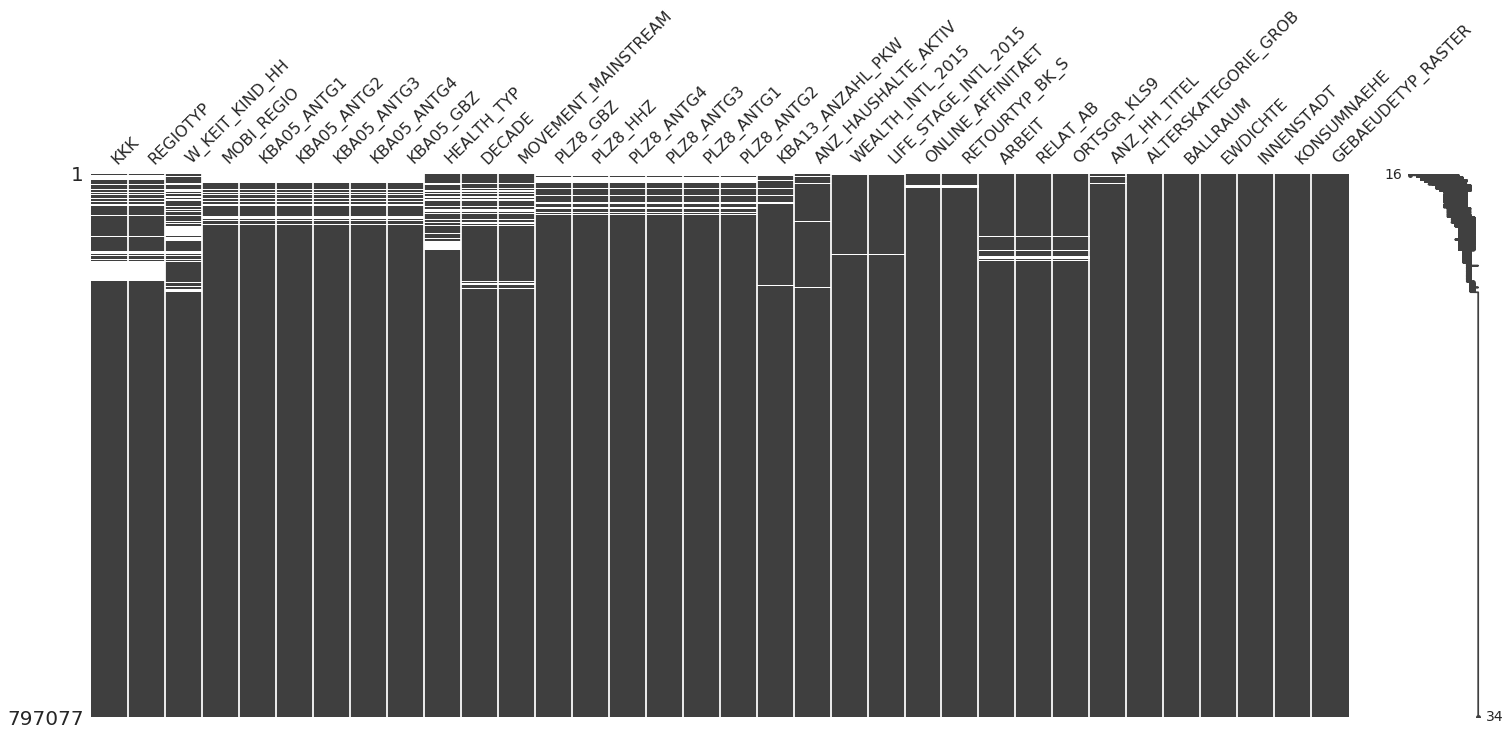

In [73]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
import missingno as msno
miss_val_list = list(missing2.index)
azdias_miss = azdias_clean[miss_val_list]
msno.matrix(azdias_miss)

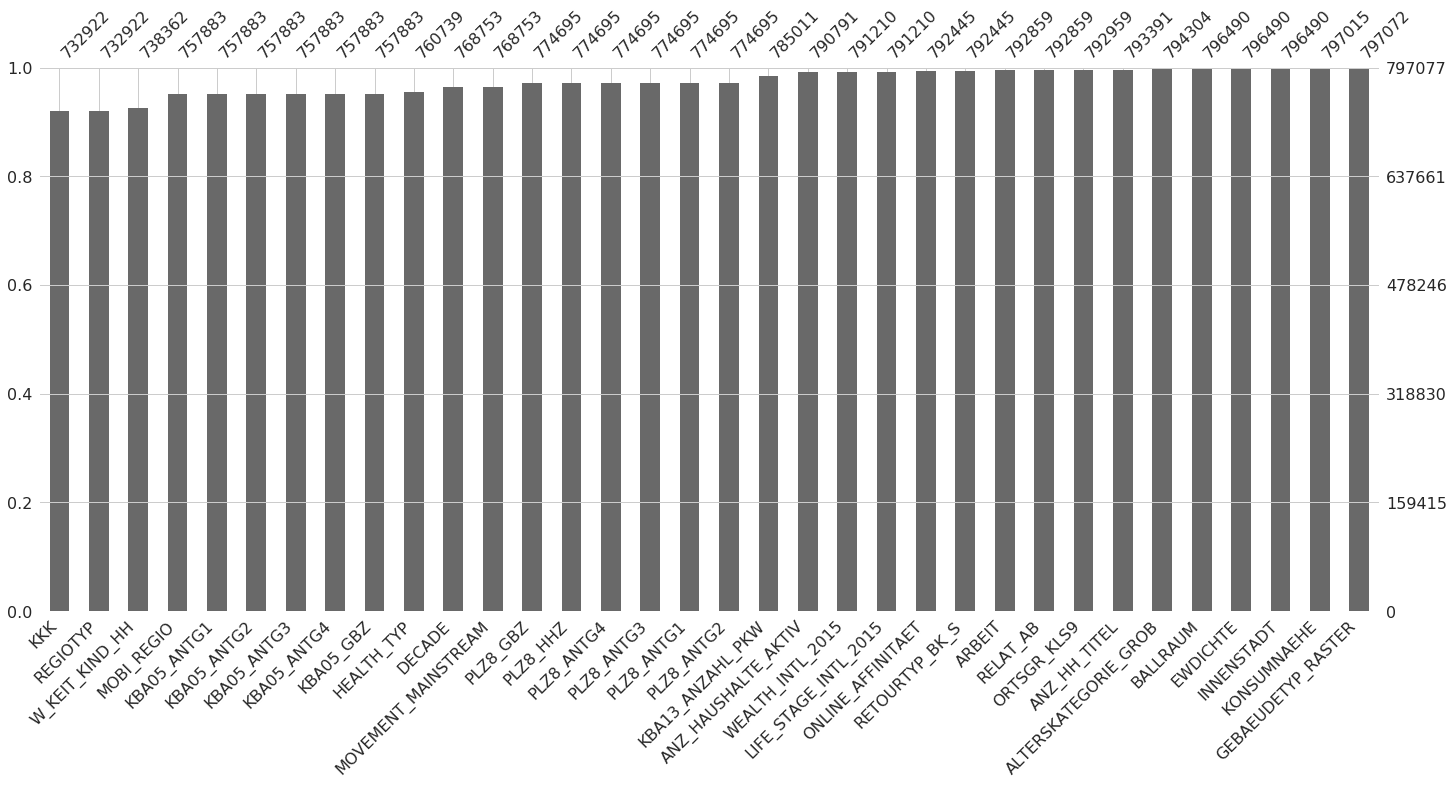

In [74]:
## bar graph version
msno.bar(azdias_miss)

- Most of the variables above have a similar number of missing values (upt to 10%). From the first plot, there are big gaps in the first two columns and some smaller ones in columns 4 to 9. Along with even smaller ones patterned in straight lines across multiple consecutive columns. With the information in the second plot, it could be possible to drop the rows that contain one or more missing values. However, this could result in the loss of 22% of the data. Hence, in order to get accurate results, it would be better to make imputations with the most frequent values by column.


In [4]:
## fit imputations
from sklearn.preprocessing import Imputer

imp = Imputer(strategy = 'most_frequent', axis = 0)
azdias_imp = imp.fit_transform(azdias_clean)
azdias_imp

array([[ 3.,  0.,  4., ...,  1.,  5.,  1.],
       [ 4.,  0.,  5., ...,  1.,  5.,  1.],
       [ 2.,  0.,  4., ...,  0.,  5.,  1.],
       ..., 
       [ 2.,  0.,  3., ...,  1.,  4.,  4.],
       [ 1.,  0.,  1., ...,  1.,  4.,  1.],
       [ 4.,  0.,  4., ...,  1.,  4.,  3.]])

In [5]:
azdias_imp.shape

(797077, 175)

In [6]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
azdias_sc = sc.fit_transform(azdias_imp)
azdias_sc

array([[ 0.20073336, -1.04370935,  0.68328531, ...,  0.53065411,
         1.17585671, -1.24936851],
       [ 1.18418644, -1.04370935,  1.40920155, ...,  0.53065411,
         1.17585671, -1.24936851],
       [-0.78271971, -1.04370935,  0.68328531, ..., -1.88446671,
         1.17585671, -1.24936851],
       ..., 
       [-0.78271971, -1.04370935, -0.04263094, ...,  0.53065411,
         0.49404106,  0.76669146],
       [-1.76617279, -1.04370935, -1.49446342, ...,  0.53065411,
         0.49404106, -1.24936851],
       [ 1.18418644, -1.04370935,  0.68328531, ...,  0.53065411,
         0.49404106,  0.09467147]])

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [85]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca= PCA()
azdias_pca = pca.fit_transform(azdias_sc)
print(pca)
print(azdias_pca)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
[[ -2.50185438e-01  -1.71751086e+00   2.61133587e+00 ...,  -4.34607794e-15
    2.13973591e-16   8.37900020e-17]
 [ -3.97122870e+00   1.39344249e+00   2.49411608e+00 ...,   1.09850769e-13
    2.08412407e-17  -1.75660096e-17]
 [ -9.01835260e-01  -5.44579410e+00   3.98981379e+00 ...,   2.41485031e-15
    2.63903922e-16   1.01274927e-16]
 ..., 
 [  4.77951725e-01  -2.51886424e+00   3.30749603e+00 ...,   8.00551690e-17
    2.07389394e-17   1.02853410e-17]
 [  6.81819237e+00  -3.65532370e+00   3.03412956e+00 ...,   1.70431675e-16
    2.44535962e-17  -4.88959877e-18]
 [  7.10401656e-01   2.88457892e+00   1.75155301e+00 ...,   5.11851912e-17
   -1.57991817e-18   1.26357952e-18]]


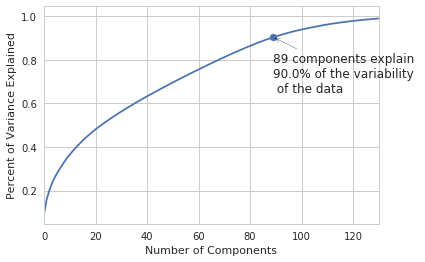

In [86]:
# Investigate the variance accounted for by each principal component.

## create scree plot
n_comps = len(pca.explained_variance_ratio_)
comp = np.arange(n_comps)
vals = pca.explained_variance_ratio_
cum_vals = np.cumsum(vals)

## how many components represent 90% of the variance?
pct = 0.9
val_pct = cum_vals[cum_vals > pct][0]
pct_comp = np.where(cum_vals == val_pct)[0][0]
plt.plot(comp, cum_vals)
plt.xlim(0, 130)
plt.xlabel('Number of Components')
plt.ylabel('Percent of Variance Explained')
plt.scatter(pct_comp, val_pct)
plt.annotate(str(pct_comp) + ' components explain \n' + str(round(val_pct, 2) * 100) + '% of the variability \n of the data',
             xy = (pct_comp, val_pct), xytext = (pct_comp, val_pct - 0.25),
            arrowprops=dict(arrowstyle='->'))
plt.show()
## use 88 components to explain 90% of the data

In [8]:
# Re-apply PCA to the data while selecting for number of components to retain.
from sklearn.decomposition import PCA
pca_2 = PCA(n_components= 89)

azdias_pca2 = pca_2.fit_transform(azdias_sc)
azdias_pca2


array([[-0.25018394, -1.71751803,  2.61121998, ...,  0.16605393,
        -1.13215551,  0.80374237],
       [-3.97122891,  1.39342721,  2.49414085, ..., -0.33329419,
         0.23219059, -0.14723299],
       [-0.9018358 , -5.44578299,  3.98980494, ..., -1.23620596,
        -0.08702944,  1.53858081],
       ..., 
       [ 0.47795123, -2.51885884,  3.307499  , ..., -1.07325586,
        -1.40585135,  0.70898828],
       [ 6.8181921 , -3.6553225 ,  3.03412335, ...,  0.87818684,
         0.65960343,  0.30412079],
       [ 0.71040134,  2.88457859,  1.75156761, ...,  0.02514232,
        -0.73398604, -0.16372306]])

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)
- used 88 principal components since it is best to use the amount that explains 90% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [9]:
## make imputed data array a dataframe 
azdias_clean2 = pd.DataFrame(azdias_imp, columns = azdias_clean.keys())
azdias_clean2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_9,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,DECADE,MOVEMENT_MAINSTREAM,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015
0,3.0,0.0,4.0,3.0,4.0,2.0,4.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,1.0,5.0,1.0
1,4.0,0.0,5.0,1.0,5.0,1.0,3.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,60.0,1.0,5.0,1.0
2,2.0,0.0,4.0,4.0,1.0,2.0,5.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,5.0,1.0
3,2.0,0.0,2.0,4.0,2.0,2.0,5.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,1.0,5.0,1.0
4,2.0,1.0,4.0,4.0,1.0,4.0,5.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,1.0,5.0,1.0


In [10]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(df, comp, side): ## df: cleaned and preprocessed dataset, comp: individual principal component component
    cols = df.columns

    pca_k_weights = pca_2.components_[comp - 1]

    pca_dict = {}
    for i in range(len(pca_k_weights)):
        pca_dict[cols[i]] = pca_k_weights[i]

    pca_order = sorted(pca_dict.items(), key = lambda x: x[1], reverse = True) 

    max_comps = pd.DataFrame(dict(pca_order), index = [comp])

    if side == 'top':
        pc_t = max_comps.iloc[:, :5]
        pc_tt = pc_t.T
        sns.barplot(y = pc_tt.index, x = pc_tt[comp], orient = 'h')
        plt.title('Top Weights of Principal Component ' + str(comp))
        plt.xlabel('Weights')
        plt.show()
        return pc_t
    
    elif side == 'bottom':
        pc_b = max_comps.iloc[:, -5:]
        pc_bt = pc_b.T
        sns.barplot(y = pc_bt.index, x = pc_bt[comp], orient = 'h')
        plt.title('Bottom Weights of Principal Component ' + str(comp))
        plt.xlabel('Weights')
        plt.show()
        return pc_b


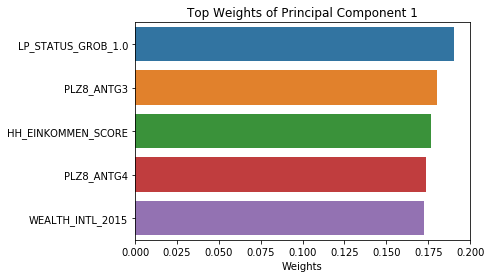

,LP_STATUS_GROB_1.0,PLZ8_ANTG3,HH_EINKOMMEN_SCORE,PLZ8_ANTG4,WEALTH_INTL_2015
1,0.190368,0.179989,0.17696,0.173482,0.17267


In [11]:
pc1_t = pca_results(azdias_clean2, 1, 'top')
pc1_t

- Top 5: LP_STATUS_GROB_1.0,  PLZ8_ANTG3, HH_EINKOMMEN_SCORE, PLZ8_ANTG4, WEALTH_INTL_2015.

- The first principal component has large positive associations with low-income earners, estimated household net income, number of 6-10 houses, wealth status, and number of 10+ houses in PLZ8

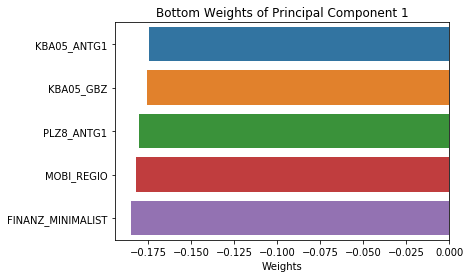

,KBA05_ANTG1,KBA05_GBZ,PLZ8_ANTG1,MOBI_REGIO,FINANZ_MINIMALIST
1,-0.174298,-0.175663,-0.180306,-0.181779,-0.185224


In [12]:
pc1_b = pca_results(azdias_clean2, 1, 'bottom')
pc1_b

- Bottom 5: KBA05_ANTG1, KBA05_GBZ, PLZ8_ANTG1, MOBI_REGIO, FINANZ_MINIMALIST
- The first principal component has large negative associations with  number of 1-2 family houses in microcell, number of buildings in microcell, number of 1-2 family houses in PLZ8, movement patterns, and low financial interest.

- Overall, the first principal component measures low financial stability in the home.

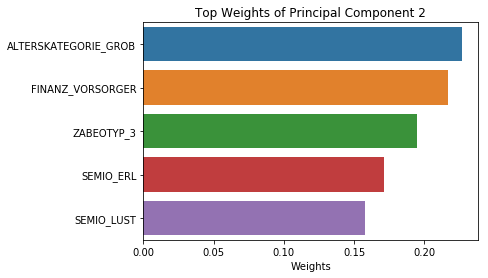

,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,SEMIO_ERL,SEMIO_LUST
2,0.226901,0.216627,0.194669,0.171446,0.157524


In [13]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc2_t = pca_results(azdias_clean2, 2, 'top')
pc2_t

- Top 5: ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, ZABEOTYP_3, SEMIO_ERL, SEMIO_LUST
- The second principal component has large positive associations with estimated age based on given name, financial preparedness, and fairly supplied energy consumption for event-oriented and sensual minded people.

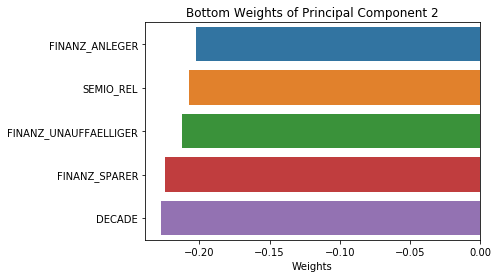

,FINANZ_ANLEGER,SEMIO_REL,FINANZ_UNAUFFAELLIGER,FINANZ_SPARER,DECADE
2,-0.202626,-0.207496,-0.212455,-0.22483,-0.227389


In [14]:
pc2_b = pca_results(azdias_clean2, 2, 'bottom')
pc2_b

- Bottom 5: SEMIO_TRADV, SEMIO_REL, FINANZ_UNAUFFAELLIGER, FINANZ_SPARER, DECADE
- The second principal component has large negative associations with generation by decade as well as inconspicuous and religious money-saving investors.

- Overall, the second principal component measures financial traits by personality and age.

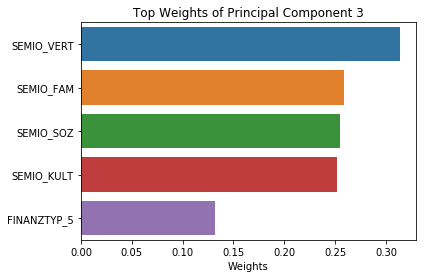

,SEMIO_VERT,SEMIO_FAM,SEMIO_SOZ,SEMIO_KULT,FINANZTYP_5
3,0.313565,0.25903,0.254474,0.251762,0.132164


In [15]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc3_t = pca_results(azdias_clean2, 3, 'top')
pc3_t

- Top 5: SEMIO_VERT, SEMIO_FAM, SEMIO_SOZ, SEMIO_KULT, FINANZTYP_5
- The third principal component has large postitive associations with investors who are dreamful, social, cultural, and family-minded.

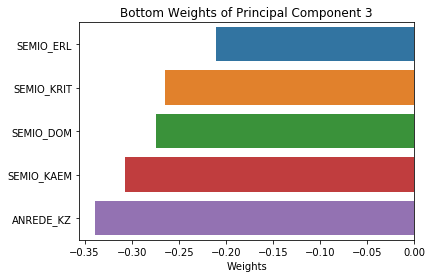

,SEMIO_ERL,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,ANREDE_KZ
3,-0.210505,-0.264234,-0.274571,-0.307562,-0.338833


In [16]:
pc3_b = pca_results(azdias_clean2, 3, 'bottom')
pc3_b

- SEMIO_ERL, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM, ANREDE_KZ
- The third principal component has large negative associations with gender and people who are critical, dominant, combative, and event-oriented. 

- The third principal component seems to measure personal traits in general.

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [66]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
scores = []
for i in range(1, 12):

    # run k-means clustering on the data and...
    print('Fitting', i, 'clusters')
    km_i = KMeans(n_clusters = i)
    km_i.fit(azdias_pca2) ## PCA transformed data 
    print(km_i.score(azdias_pca2))
    # compute the average within-cluster distances.
    scores.append(abs(km_i.score(azdias_pca2)))

Fitting 1 clusters
-125412313.855
Fitting 2 clusters
-115480963.904
Fitting 3 clusters
-110520039.427
Fitting 4 clusters
-107309859.369
Fitting 5 clusters
-104907830.552
Fitting 6 clusters
-103395270.312
Fitting 7 clusters
-101600849.821
Fitting 8 clusters
-100398685.605
Fitting 9 clusters
-98406087.1887
Fitting 10 clusters
-97013509.7705
Fitting 11 clusters
-95867133.2402


In [67]:
scores

[125412313.8551756,
 115480963.90432324,
 110520039.42679465,
 107309859.36874832,
 104907830.55214767,
 103395270.31169398,
 101600849.82103053,
 100398685.60472849,
 98406087.188656926,
 97013509.770480096,
 95867133.24022162]

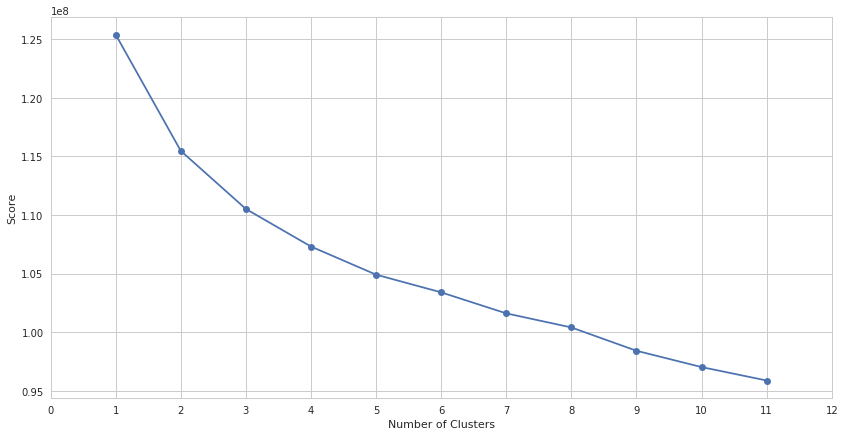

In [69]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize= (14, 7))
plt.plot(range(1, 12), scores, marker = 'o')
plt.xticks(np.arange(0, 13, 1))
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

- Use 5 clusters since its corresponding score marks an elbow in the scree plot.

In [17]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans
no_clusters = 5
kmf = KMeans(n_clusters= no_clusters)
clusters = kmf.fit_predict(azdias_pca2)
clusters

array([2, 0, 2, ..., 2, 1, 4], dtype=int32)

In [18]:
## add cluster variable
azdias_clean2['CLUSTER'] = clusters
azdias_clean2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,DECADE,MOVEMENT_MAINSTREAM,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,CLUSTER
0,3.0,0.0,4.0,3.0,4.0,2.0,4.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,80.0,1.0,5.0,1.0,2
1,4.0,0.0,5.0,1.0,5.0,1.0,3.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,60.0,1.0,5.0,1.0,0
2,2.0,0.0,4.0,4.0,1.0,2.0,5.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,80.0,0.0,5.0,1.0,2
3,2.0,0.0,2.0,4.0,2.0,2.0,5.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,80.0,1.0,5.0,1.0,1
4,2.0,1.0,4.0,4.0,1.0,4.0,5.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,80.0,1.0,5.0,1.0,2


### Discussion 3.1: Apply Clustering to General Population

- Used five clusters since the plot above, although a bit vague, seems to point an elbow at 5. After this point, the decrease in score after 5 seemed to change in direction compared to the one preceding 5.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [19]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter= ';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [20]:
print(customers.shape)

(191652, 85)


In [21]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_9,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,DECADE,MOVEMENT_MAINSTREAM,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015
12933,3.0,1,3,1,5,2,2,3,0,2.0,...,0,0,0,0,0,0,50.0,1.0,NaN,NaN
57873,4.0,0,5,1,5,1,3,1,0,1.0,...,0,1,0,0,0,0,NaN,NaN,2.0,3.0
34910,4.0,0,3,2,4,2,3,1,0,1.0,...,0,0,0,0,0,0,70.0,1.0,NaN,NaN
374,3.0,0,3,2,4,2,3,1,0,1.0,...,0,0,0,0,0,0,70.0,1.0,NaN,NaN
11068,4.0,0,4,1,5,1,2,2,0,1.0,...,0,0,0,0,0,0,60.0,1.0,NaN,NaN


In [22]:
customers_clean.shape

(141590, 174)

In [23]:
## check which columns are missing from the customers data
missing_var = list(set(sorted(azdias_clean.columns)) - set(sorted(customers_clean.columns)))
azdias_clean[missing_var].sum()
## does not sound importand so it would be feasible to add an 'empty' column in the customers data for this specific variable

GEBAEUDETYP_5.0    1
dtype: int64

In [24]:
indx = azdias_clean.columns.get_loc(missing_var[0]) ## index of GEBAEUDETYP_5.0 in demographics data
customers_clean.insert(indx, missing_var[0], 0)


In [25]:
customers_clean.shape

(141590, 175)

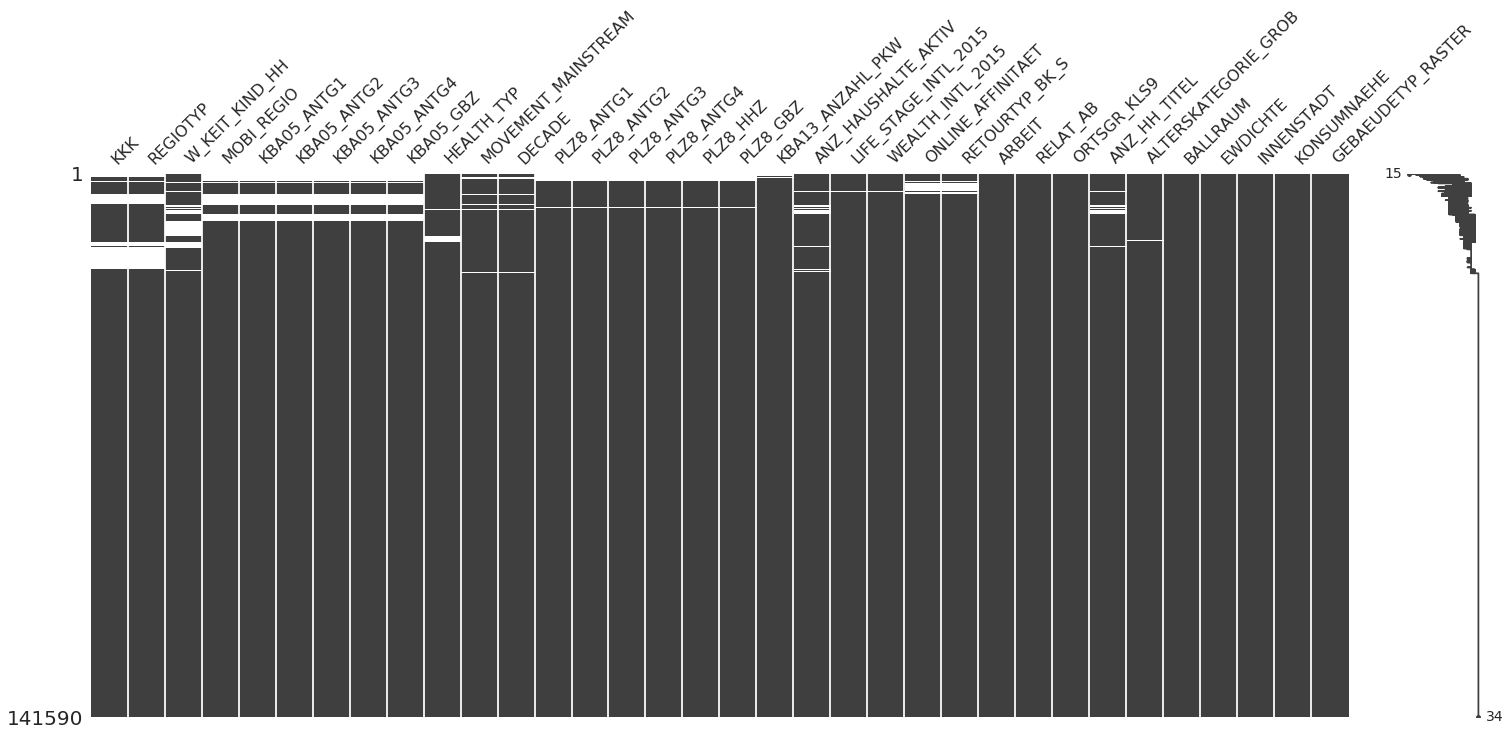

In [69]:
## check missing values on customers data
import missingno as msno
miss_val_list = list(missing2.index)
customers_miss = customers_clean[miss_val_list]
msno.matrix(customers_miss)

- There is a lot of white lines, it would be better to drop the missing values in order and see how many observations remain.

In [26]:
## make imputations
customers_imp = imp.transform(customers_clean)
customers_imp

array([[ 3.,  1.,  3., ...,  1.,  5.,  1.],
       [ 4.,  0.,  5., ...,  1.,  2.,  3.],
       [ 4.,  0.,  3., ...,  1.,  5.,  1.],
       ..., 
       [ 3.,  0.,  4., ...,  1.,  2.,  2.],
       [ 3.,  0.,  3., ...,  1.,  5.,  1.],
       [ 2.,  0.,  5., ...,  1.,  3.,  3.]])

In [27]:
## Standard Scaler
customers_sc = sc.transform(customers_imp)
customers_sc

array([[ 0.20073336,  0.95812115, -0.04263094, ...,  0.53065411,
         1.17585671, -1.24936851],
       [ 1.18418644, -1.04370935,  1.40920155, ...,  0.53065411,
        -0.86959024,  0.09467147],
       [ 1.18418644, -1.04370935, -0.04263094, ...,  0.53065411,
         1.17585671, -1.24936851],
       ..., 
       [ 0.20073336, -1.04370935,  0.68328531, ...,  0.53065411,
        -0.86959024, -0.57734852],
       [ 0.20073336, -1.04370935, -0.04263094, ...,  0.53065411,
         1.17585671, -1.24936851],
       [-0.78271971, -1.04370935,  1.40920155, ...,  0.53065411,
        -0.18777459,  0.09467147]])

In [28]:
## Fit components
customers_pca2 = pca_2.transform(customers_sc)
customers_pca2

array([[ -6.93686386e-01,   3.05072139e+00,  -3.49693615e+00, ...,
          2.11720198e-01,  -1.01572772e+00,   5.84250544e-01],
       [ -4.66409604e+00,   5.81344509e-01,   1.70040033e+00, ...,
         -2.04133912e+00,  -3.81920039e-03,  -2.16233862e-01],
       [ -2.07117135e+00,   3.52330981e-01,   2.31294234e+00, ...,
         -4.69098915e-01,   2.22608703e-01,  -1.10319810e+00],
       ..., 
       [ -3.06566230e+00,   2.16974037e+00,   1.42486979e+00, ...,
         -1.13895157e+00,  -3.19615402e-02,   6.07520614e-01],
       [  5.05272392e+00,   1.50640997e+00,   2.90618729e+00, ...,
         -7.05118602e-01,  -6.85170262e-01,  -1.29877571e+00],
       [ -5.58445790e+00,  -1.91209788e+00,   2.41929203e+00, ...,
          1.33507225e+00,   1.36669087e-01,   5.37962606e-01]])

In [29]:
#no_clusters = 5
#kmf = KMeans(n_clusters= no_clusters)
clusters = kmf.predict(customers_pca2)
clusters

array([4, 0, 0, ..., 0, 4, 0], dtype=int32)

In [30]:
customers_clean = pd.DataFrame(customers_imp, columns = customers_clean.keys())

In [31]:
## add cluster variable
customers_clean['CLUSTER'] = clusters
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,DECADE,MOVEMENT_MAINSTREAM,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,CLUSTER
0,3.0,1.0,3.0,1.0,5.0,2.0,2.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,50.0,1.0,5.0,1.0,4
1,4.0,0.0,5.0,1.0,5.0,1.0,3.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,90.0,1.0,2.0,3.0,0
2,4.0,0.0,3.0,2.0,4.0,2.0,3.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,70.0,1.0,5.0,1.0,0
3,3.0,0.0,3.0,2.0,4.0,2.0,3.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,70.0,1.0,5.0,1.0,2
4,4.0,0.0,4.0,1.0,5.0,1.0,2.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,60.0,1.0,5.0,1.0,0


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [53]:
## get number of values by cluster and add the 20+ missing dataset from step 1.1.3
azdias_clusters = pd.DataFrame({'cluster_counts':azdias_clean2['CLUSTER'].value_counts()})
azdias_clusters.loc[-1] = azdias_above_20.shape[0]
azdias_clusters['cluster_pct'] = (azdias_clusters['cluster_counts']/azdias_clusters['cluster_counts'].sum())*100
azdias_clusters

,cluster_counts,cluster_pct
4,212572,23.851772
1,165113,18.526606
0,160903,18.054220
2,139425,15.644268
3,119064,13.359649
-1,94144,10.563485


In [54]:
## do the same for customers

## find the number or rows for the 20+ list for customers by
## taking the difference in rows between the original dataset and the clean dataset
customer_clusters = pd.DataFrame({'cluster_counts':customers_clean['CLUSTER'].value_counts()})
## counts for cluster -1
clust_n1_count = customers.shape[0] - customers_clean.shape[0] 
customer_clusters.loc[-1] = clust_n1_count

## calculate percentages
customer_clusters['cluster_pct'] = (customer_clusters['cluster_counts']/customer_clusters['cluster_counts'].sum())*100

customer_clusters

,cluster_counts,cluster_pct
3,63597,33.183583
0,38528,20.103104
4,31500,16.436040
2,5363,2.798301
1,2602,1.357669
-1,50062,26.121303


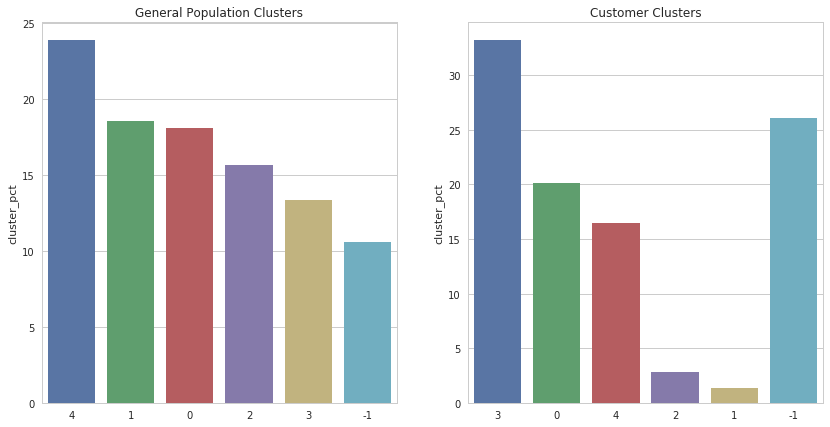

In [55]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plt.figure(figsize = (14, 7))
plt.subplot(1, 2, 1)
plt.title('General Population Clusters')
sns.barplot(x = azdias_clusters.index, y = azdias_clusters['cluster_pct'], order=azdias_clusters.index)

plt.subplot(1, 2, 2)
plt.title('Customer Clusters')
sns.barplot(x = customer_clusters.index, y = customer_clusters['cluster_pct'], order= customer_clusters.index)
plt.show()

## Big Clusters
- In the customers data, cluster 3 is overrepresented compared to the general population, where cluster 4 is overrepresented. In the customer plot, cluster 3 represents one third of the clients, whereas cluster 4 represents nearly a quarter of the general population of Germany.  
- On the other hand, cluster 3 has the second lowest representation in the demographics data, representing about 13% of the general population.
- Also, cluster 4 has the fourth largest representation of customers compared to the general population.
- The special data that has more than 20 traits missing represents a quarter of the company's clients. Therefore, it would be worth to include a brief analysis on this cluster as well.

In [56]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid = sc.inverse_transform(pca_2.inverse_transform(kmf.cluster_centers_))
centroid_df = pd.DataFrame(centroid, columns = customers_clean.keys()[:-1]) ## remove cluster column to add columns


In [57]:
## get cluster 3 and 4 info from first principal component
centroid_df.loc[[3,4],list(pc1_t.columns)]

,LP_STATUS_GROB_1.0,PLZ8_ANTG3,HH_EINKOMMEN_SCORE,PLZ8_ANTG4,WEALTH_INTL_2015
3,0.008013,1.171035,2.366911,0.359054,2.058638
4,0.683820,2.243161,5.386305,1.112349,4.197432


In [90]:
## get cluster 3 and 4 info from second principal component
centroid_df.loc[[3,4],list(pc2_t.columns)]

,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,SEMIO_ERL,SEMIO_LUST
3,3.21510,4.029220,0.312085,4.958440,5.022079
4,3.38459,4.332573,0.692702,5.370589,5.124963


#### Cluster 3
- In the customer data population, cluster 3 represents people who are prosperous with very high income, a lower share (1) of 6-10 family homes, and no 10+ family homes.
- This cluster also represents lowly-affinitized event-oriented, sensual-minded middle-aged people with low financial preparedness and 31.2% probability of fairly-supplied energy consumption.

#### Cluster 4
- Cluster 4 in the demographics data population, on the other hand, represents less affluent people with lower to average share of 6+ family homes.
- This cluster also represents lowly-affinitized event-oriented, sensual-minded middle-aged people with low preparedness and 69% probability of fairly supplied energy consumption

#### Cluster -1

- In the general population, cluster -1 has special data where people have more than 20 features missing. By the way that the original data was encoded and cleaned, the customer's -1 cluster should have similar insights as its demographics counterpart. Therefore, I am going to use the averages from the demographics' 20+ missing data subset to give an idea on how the -1 cluster says about its customers.

In [84]:
cluster_n1 = pd.DataFrame(azdias_above_20.mean(skipna= True), columns = ['average'])
##calculate average of values with features from the first principal component 
cluster_n1.loc[['LP_STATUS_GROB', 'PLZ8_ANTG3', 'HH_EINKOMMEN_SCORE', 'PLZ8_ANTG4']]

,average
LP_STATUS_GROB,2.202423
PLZ8_ANTG3,1.000000
HH_EINKOMMEN_SCORE,2.020463
PLZ8_ANTG4,0.363636


In [94]:
## features from second principal component
cluster_n1.loc[['ALTERSKATEGORIE_GROB','FINANZ_VORSORGER','ZABEOTYP','SEMIO_ERL', 'SEMIO_LUST']]

,average
ALTERSKATEGORIE_GROB,2.436577
FINANZ_VORSORGER,3.131490
ZABEOTYP,3.221756
SEMIO_ERL,3.288898
SEMIO_LUST,4.571348


- Cluster -1 in the customers dataset seems to represent average to high income earners with low shares of 6-10 family homes.
- This cluster also seems to have average to highly-affinitized event-oriented, sensual-minded adults between 30 to 45 years old with average financial preparedness. 

## Small Clusters
- In the customers data, cluster 1 is the most underrepresented compared to the general population, where this cluster is the second largest cluster. Cluster 1 represents about 1% of the clients and 18.5% of the general population.
- The second lowest cluster is cluster 2, which represents almost 3% of the customers.

In [95]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

## get cluster 1 info for first principal component
centroid_df.loc[[1, 2],list(pc1_t.columns)]

,LP_STATUS_GROB_1.0,PLZ8_ANTG3,HH_EINKOMMEN_SCORE,PLZ8_ANTG4,WEALTH_INTL_2015
1,0.887262,2.318088,5.552322,1.194594,4.321301
2,0.152093,1.022929,3.925001,0.252080,2.507633


In [96]:
centroid_df.loc[[1, 2],list(pc2_t.columns)]

,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,SEMIO_ERL,SEMIO_LUST
1,1.881851,2.101853,0.069826,3.578217,3.198291
2,1.942426,2.208361,0.037502,3.639828,3.248435


#### Cluster 1
- In the customer data population, cluster 1 represents low-income earners with lower to average shares of 6+ family homes.
- This cluster also represents average to highly affinitized adults between 30 to 45 years old with high finanial prepraredness and 6% probability of fair energy consumption.

#### Cluster 2
- In the customer data population, cluster 2 represents average income earners with lower shares of 6-10 family homes.
- This cluster also represents average to highly affinitized adults between 30 to 45 years old with high finanial prepraredness and 3.7% probability of fair energy consumption.

### Discussion 3.3: Compare Customer Data to Demographics Data

- The discussions above are based on the interpretations of the first principal component's positive values of the population dataset. The centroid values helped identify the kinds of people that belong in said clusters according to the features with the highest increasing components.
- In conclusion, the customers of the mailing service company are likely wealthy and financially prosperous middle-aged people with low to no share in a large home. However, these customers also have low finiancial preparedness as well as low affinity in sensual and event-oriented personalities.
- Also, the least likely group of customers are the opposite - younger low income earners with high financial preparedness as well as higher affinity in sensual and event-oriented personalities.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.